<a href="https://colab.research.google.com/github/geoffwoollard/gpu-speedups-mbptechtalk2020/blob/master/4_numba_image_convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See Vincent Lunot's blog entries ([Part3](https://www.vincent-lunot.com/post/an-introduction-to-cuda-in-python-part-3/), [Part5](https://www.vincent-lunot.com/post/an-introduction-to-cuda-in-python-part-5/)) on image convolution for more detail.

In [0]:
from numba import cuda
import numpy as np
import skimage.data
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
%matplotlib inline


# Reference image

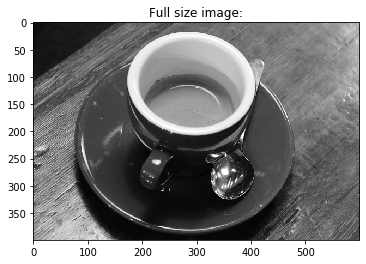

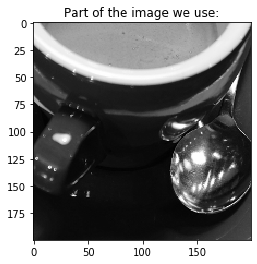

In [14]:
full_image = rgb2gray(skimage.data.coffee()).astype(np.float32) / 255
plt.figure()
plt.imshow(full_image, cmap='gray')
plt.title("Full size image:")
image = full_image[150:350, 200:400].copy() # We don't want a view but an array and therefore use copy()
plt.figure()
plt.imshow(image, cmap='gray')
plt.title("Part of the image we use:")
plt.show()

# Convolution Kernel

In [0]:
@cuda.jit
def convolve(result, mask, image):
    # expects a 2D grid and 2D blocks,
    # a mask with odd numbers of rows and columns, (-1-) 
    # a grayscale image
    
    # (-2-) 2D coordinates of the current thread:
    i, j = cuda.grid(2) 
    
    # (-3-) if the thread coordinates are outside of the image, we ignore the thread:
    image_rows, image_cols = image.shape
    if (i >= image_rows) or (j >= image_cols): 
        return
    
    # To compute the result at coordinates (i, j), we need to use delta_rows rows of the image 
    # before and after the i_th row, 
    # as well as delta_cols columns of the image before and after the j_th column:
    delta_rows = mask.shape[0] // 2 
    delta_cols = mask.shape[1] // 2
    
    # The result at coordinates (i, j) is equal to 
    # sum_{k, l} mask[k, l] * image[i - k + delta_rows, j - l + delta_cols]
    # with k and l going through the whole mask array:
    s = 0
    for k in range(mask.shape[0]):
        for l in range(mask.shape[1]):
            i_k = i - k + delta_rows
            j_l = j - l + delta_cols
            # (-4-) Check if (i_k, j_k) coordinates are inside the image: 
            if (i_k >= 0) and (i_k < image_rows) and (j_l >= 0) and (j_l < image_cols):  
                s += mask[k, l] * image[i_k, j_l]
    result[i, j] = s

# Run the kernel

Mask shape: (13, 13)
Mask first (3, 3) elements:
 [[0.003212   0.00850507 0.00135691]
 [0.00664057 0.00126645 0.00252135]
 [0.00955635 0.01095357 0.00136325]]
Blocks dimensions: (32, 32)
Grid dimensions: (7, 7)


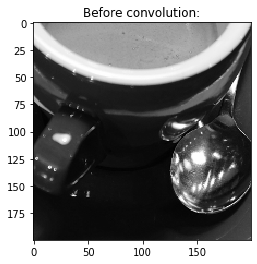

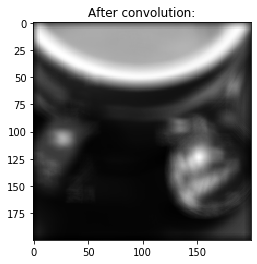

In [16]:
# We preallocate the result array:
result = np.empty_like(image)

# We choose a random mask:
mask = np.random.rand(13, 13).astype(np.float32) 
mask /= mask.sum()  # We normalize the mask
print('Mask shape:', mask.shape)
print('Mask first (3, 3) elements:\n', mask[:3, :3])

# We use blocks of 32x32 pixels:
blockdim = (32, 32)
print('Blocks dimensions:', blockdim)

# We compute grid dimensions big enough to cover the whole image:
griddim = (image.shape[0] // blockdim[0] + 1, image.shape[1] // blockdim[1] + 1)
print('Grid dimensions:', griddim)

# We apply our convolution to our image:
convolve[griddim, blockdim](result, mask, image)

# We plot the result:
plt.figure()
plt.imshow(image, cmap='gray')
plt.title("Before convolution:")
plt.figure()
plt.imshow(result, cmap='gray')
plt.title("After convolution:")
plt.show()

# Benchmark / compare
Our custom numba kernel vs one in `scipy`

## Error

In [17]:
from scipy.ndimage.filters import convolve as scipy_convolve

scipy_result = scipy_convolve(image, mask, mode='constant', cval=0.0, origin=0)
print('Maximum relative error:', np.max(np.abs(result - scipy_result) / np.abs(scipy_result)))

Maximum relative error: 1.1900645e-07


## Timing

In [18]:
%timeit convolve[griddim, blockdim](result, mask, image)


100 loops, best of 3: 2.25 ms per loop


In [19]:
scipy_result = np.empty_like(image)
%timeit scipy_convolve(image, mask, output=scipy_result, mode='constant', cval=0.0, origin=0)

100 loops, best of 3: 9.02 ms per loop


In [20]:
d_image = cuda.to_device(image)
d_mask = cuda.to_device(mask)
d_result = cuda.to_device(result)
%timeit convolve[griddim, blockdim](d_result, d_mask, d_image)

The slowest run took 913.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 229 µs per loop
